# **Question 1** - Adaptive Runge-Kutte Integrator

The Runge-Kutte method is as follows:
1. Step to the halfway point and evaluate the derivative there:
$$ f_0 = f(x, y)$$
$$y_1 = y(x) + \frac{h}{2}f_0$$
$$f_1 = f(x + \frac{h}{2}, y_1)$$

2. Repeat step 1, but use $f_1$ to step to the halfway point and re-evaluate the derivative:
$$y_2 = y(x) + \frac{h}{2}f_1$$
$$f_2 = f(x + \frac{h}{2}, y_2)$$

3. Now use $f_2$ to step across the entire interval and evaluate the derivative there:
$$y_3 = y(x) + hf_2$$
$$f_3 = f(x + h, y_3)$$

4. Finally, the value of $y$ at $x + h$ is given by:
$$y(x + h) = y(x) + \frac{h}{6}(f_0 + 2f_1 + 2f_2 + f_3)$$


For an eccentric orbit, it doesn't always make sense to have a constant step size $h$, as the planet does not spend equal amounts of time at each point of the orbit. In this case, it is more time-efficient to make an adaptive step size. To do this:

1. Take an RK4 step with the current step size $h$ and compare with the result you get if you take two steps with step size $h/2$. The difference between these two is a measure of the error.

2. If the error is smaller than the desired tolerance, keep the result and increase $h$ by a factor of 2. If the error is larger than the desired tolerance, reject the step and try again with $h$ smaller by a factor of 2.

3. Repeat. You will need to adjust the final step size so that the final value of time is exactly $t = 2\pi$.

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def derivs_func(t, x):

    # x = [x, y, vx, vy]
    rad = (x[0]**2 + x[1]**2)**0.5 # New Radius
    vxdot = (-1*x[0])/(rad**3)
    vydot = (-1*x[1])/(rad**3)
    xdot = x[2]
    ydot = x[3]

    new_x = np.array([xdot, ydot, vxdot, vydot])
    return new_x

def runge_kutta_integration(num_steps, dt, x_init, derivs):
    # Do Runge-Kutta Integration
    x = np.zeros((num_steps, len(x_init)))
    x[0] = x_init

    for i in range(1, num_steps):    
        f = derivs((i-1)*dt, x[i-1])
        f1 = derivs((i-1)*dt + dt/2, x[i-1] + f*dt/2)
        f2 = derivs((i-1)*dt + dt/2, x[i-1] + f1*dt/2)
        f3 = derivs(i*dt, x[i-1] + f2*dt)

        x[i] = x[i-1] + dt*(f + 2*f1 + 2*f2 + f3)/6

    return x

def runge_kutta_integration_adaptive(x_init, derivs_func, t_final, h_init, tol):
    t = 0
    x_array = [x_init]
    h_array = [h_init]
    count = 1

    while t < t_final and count < 100000:
        if t + h_array[-1] > t_final:
            # Last Step
            h = t_final - t
        else:
            h = h_array[-1]

        cur_x = x_array[-1]

        # Take one full step
        new_x_full = runge_kutta_integration(2, h, cur_x, derivs_func)[-1]

        # Take two half steps
        new_x_half = runge_kutta_integration(3, h/2, cur_x, derivs_func)[-1]
        
        x_full = new_x_full[0]
        y_full = new_x_full[1]

        x_half = new_x_half[0]
        y_half = new_x_half[1]

        # Calculate the error from the radii
        error = abs(np.sqrt(x_full**2 + y_full**2) - np.sqrt(x_half**2 + y_half**2))


        if error.any() < tol:
            # Acceptable Error
            # Take full step and append to x_array
            x_array.append(new_x_full.copy())
            t += h
            h_array.append(h*2) # Double h for next step
        else:
            # Unacceptable Error
            # Reject Step and try again with h = h/2
            h_array.append(h/2)

        count += 1
    
    return x_array, count

In [22]:
n_steps = 42148
dt = 2*np.pi/n_steps
e = 0.9
r = 1 - e
x_initial = np.array((r, 0, 0, np.sqrt(2/r - 1)))

rk4 = runge_kutta_integration(n_steps, dt, x_initial, derivs_func)
static_error = abs(np.sqrt(rk4[-1][0]**2 + rk4[-1][1]**2) - np.sqrt(rk4[0][0]**2 + rk4[0][1]**2))

while static_error > 1e-6:
    n_steps += 1
    dt = 2*np.pi/n_steps
    rk4 = runge_kutta_integration(n_steps, dt, x_initial, derivs_func)
    static_error = abs(np.sqrt(rk4[-1][0]**2 + rk4[-1][1]**2) - np.sqrt(rk4[0][0]**2 + rk4[0][1]**2))

print(f"Static Error = {static_error} with {n_steps} steps")

Static Error = 9.99977806698249e-07 with 42149 steps


In [13]:
tolerance = 1e-6
h_init = (2*np.pi)/10000
final_t = 2*np.pi
e = 0.9
r = 1 - e
x_initial = np.array((r, 0, 0, np.sqrt(2/r - 1)))

rk4_adap, count = runge_kutta_integration_adaptive(x_initial, derivs_func, final_t, h_init, tolerance)
rk4_adap = np.array(rk4_adap)
print(f"Steps required for adaptive integration with 1e-6 tolerance = {count}")

Steps required for adaptive integration with 1e-6 tolerance = 23591


(9728, 4)


Text(0.5, 1.0, 'RK-4, Adaptive')

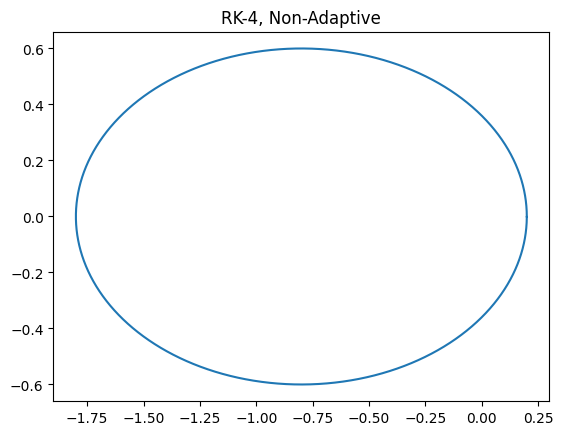

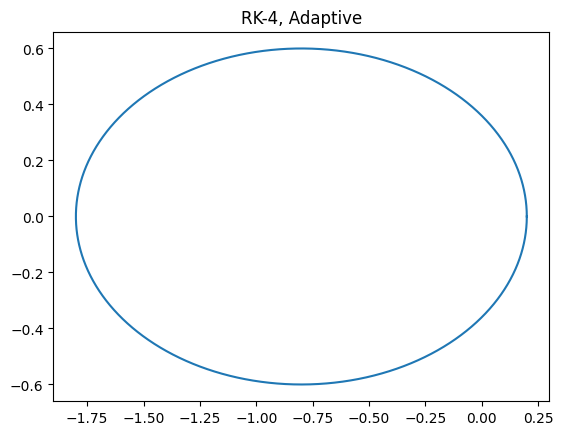

In [9]:
print(rk4_adap.shape)
plt.figure(1)
plt.plot(rk4[:, 0], rk4[:, 1])
plt.title("RK-4, Non-Adaptive")

plt.figure(2)
plt.plot(rk4_adap[:, 0], rk4_adap[:, 1])
plt.title("RK-4, Adaptive")

The number of steps required to get an error of less than $1 \times 10^{-6}$:
- Non-adaptive: 42149 steps
- Adaptive: 23591 steps

# **Question 2** - Method of Lines